# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Настройка ширины ячейки и загрузка необходимых библиотек

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn. metrics import precision_recall_curve
from sklearn.metrics import f1_score 

from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.dummy import DummyClassifier

## Импорт данных, приведение типов, визуализация распределений

Импорт данных

In [2]:
df=pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


- Отмечаем, что 10% значений для параметра tenure (сколько лет человек является клиентом банка) отсутстуют. В остальном данные полные
- Типы данных адекватны, однако значениям tenure (как показал дальнейший анализ) следует присвоить целочисленный тип

In [5]:
df['Tenure']=df['Tenure'].astype('Int64')

- Убираем столбцы, которые не нужны для построения модели

In [6]:
df=df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

Приводим имена столбцов к стандартному виду

In [7]:
df.columns=df.columns.str.lower()

Визуализируем оставшиеся данные для анализа их распределений:

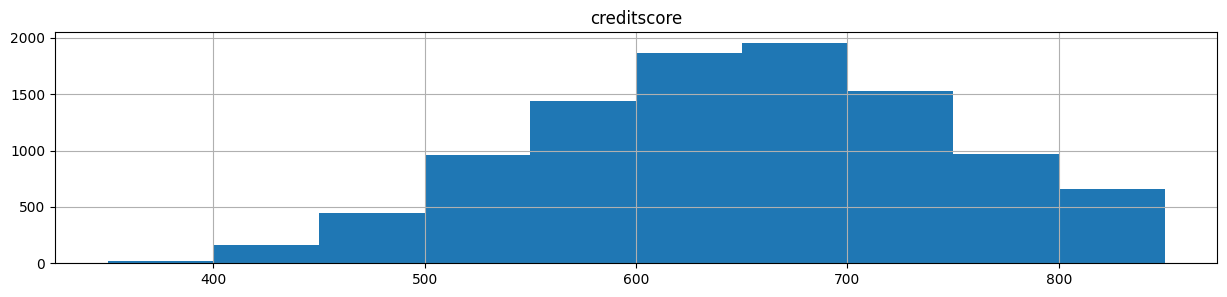

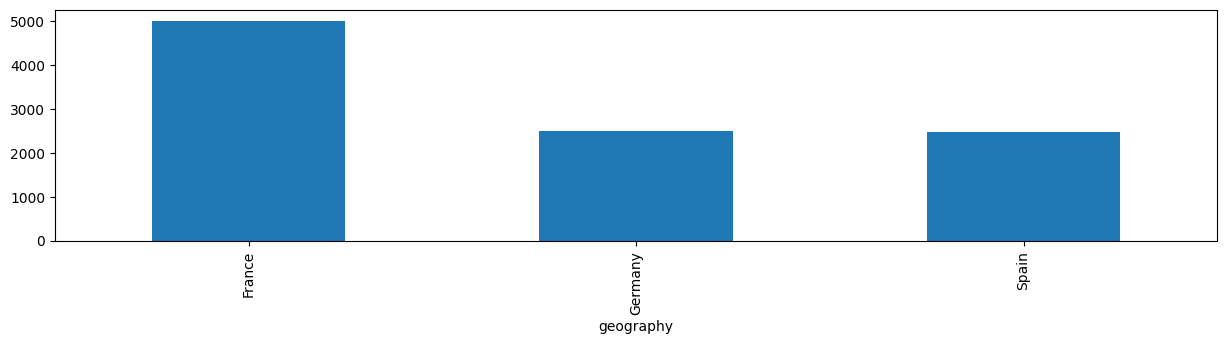

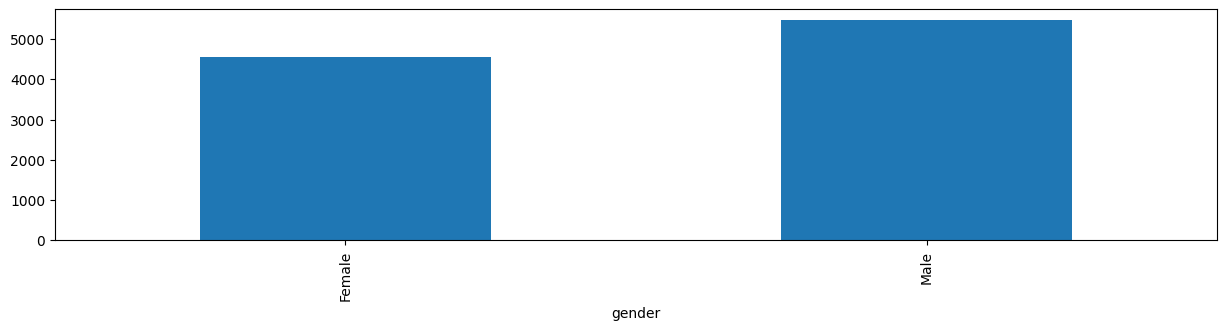

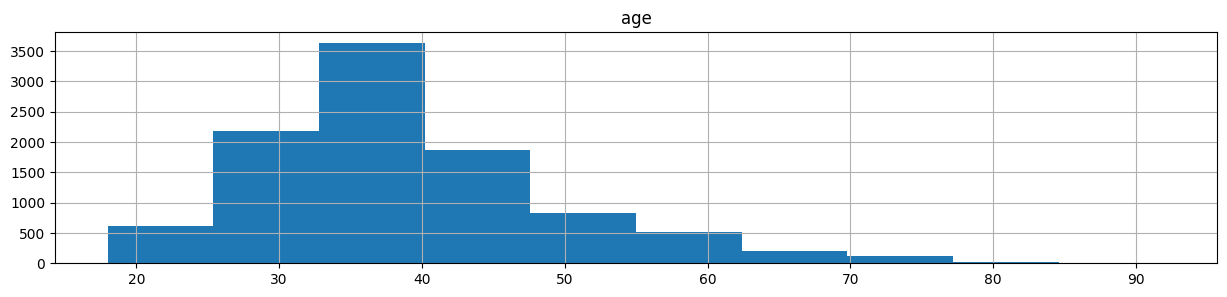

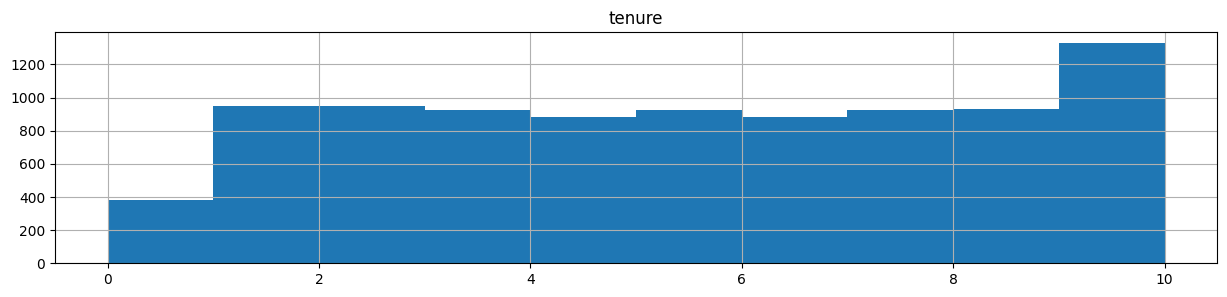

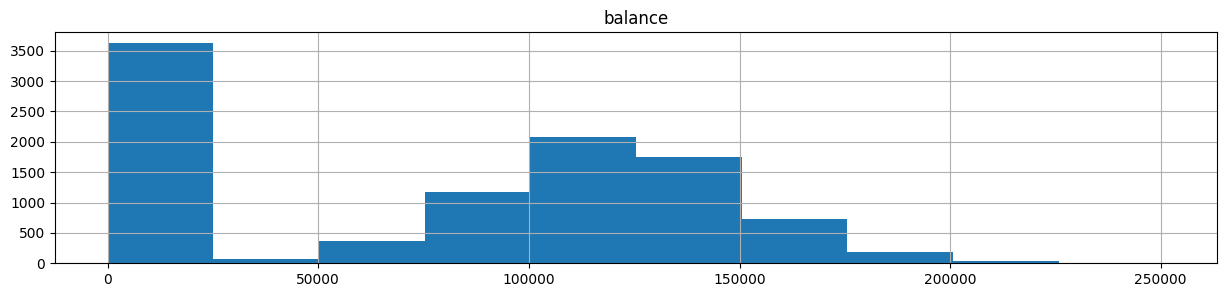

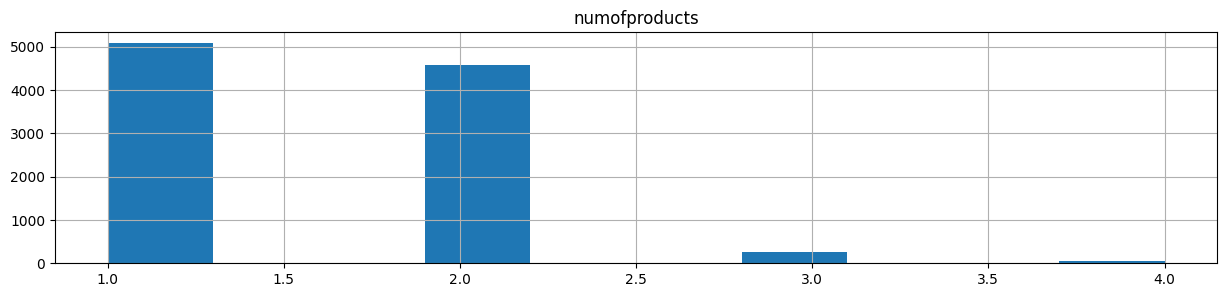

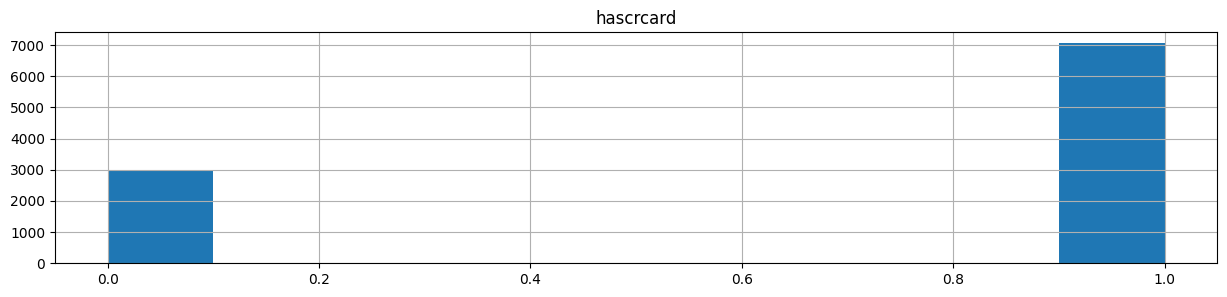

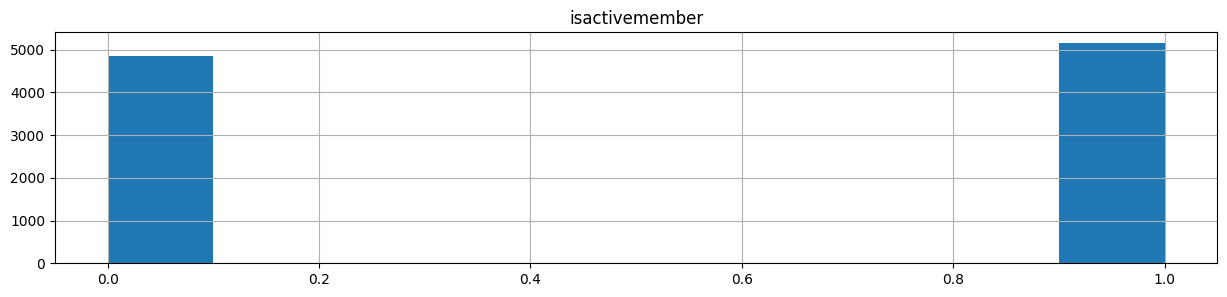

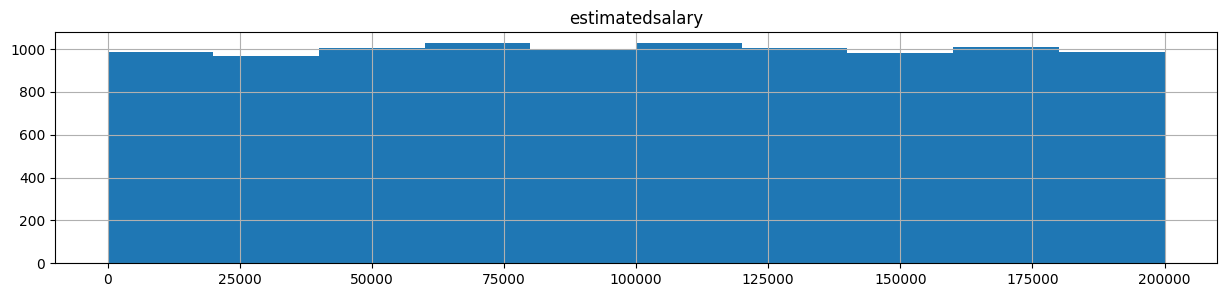

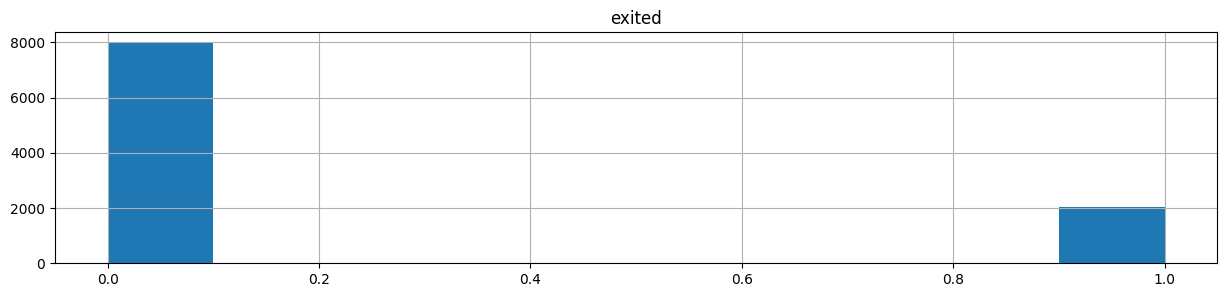

In [8]:
for column in df.columns:
    if df[column].dtype != 'object':
        df.hist(column=column, figsize = (15,3))
        plt.show()
    else:
        df.groupby (column)[column].count().plot(y=column, kind='bar', figsize = (15,3));
        plt.show()

Входные данные выглядят адекватно. При этом
1) отмечается дисбаланс классов целевого признака (доля ушедших клиентов - около 20%)
2) необходимо доп. исследование параметра tenure

Распределение tenure характеризуется относительно редкими значениями 0. Его необходимо исследовать дополнительно, тк это может помочь верно заполнить пропуски - возможно, есть основание присвоить пропущенным данным значение 0.

### Доп. исследование параметра tenure

Сопоставим распределение других параметров при наличии и отсутствии значений в столбце tenure

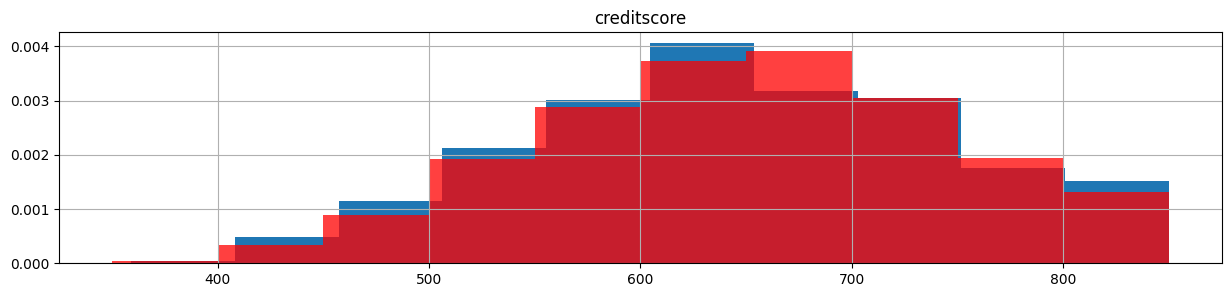

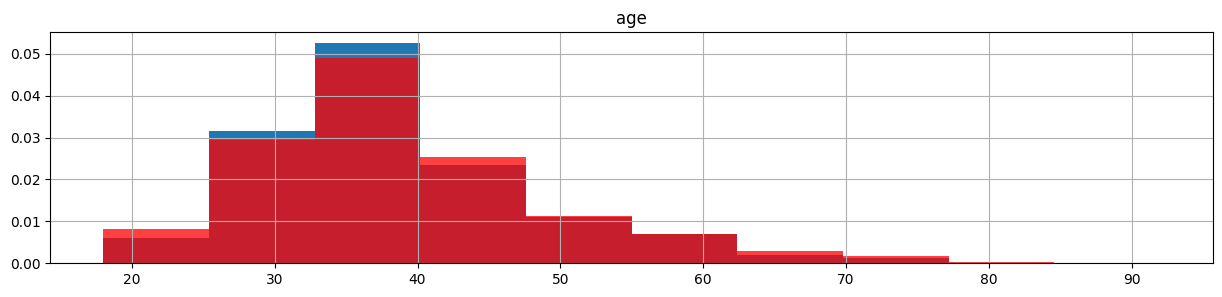

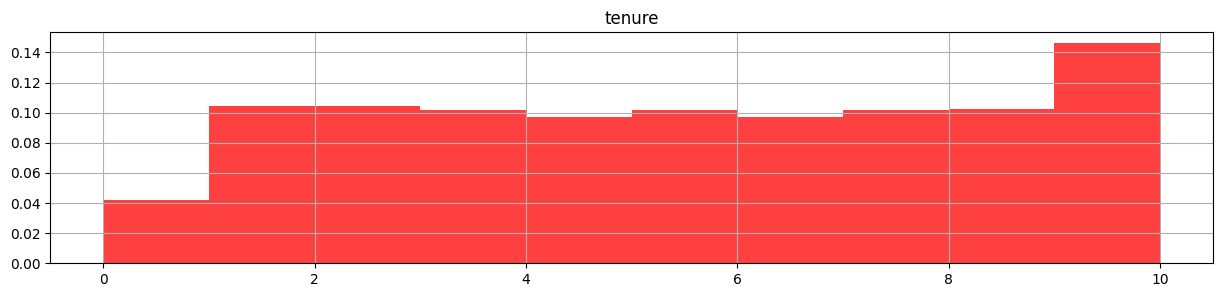

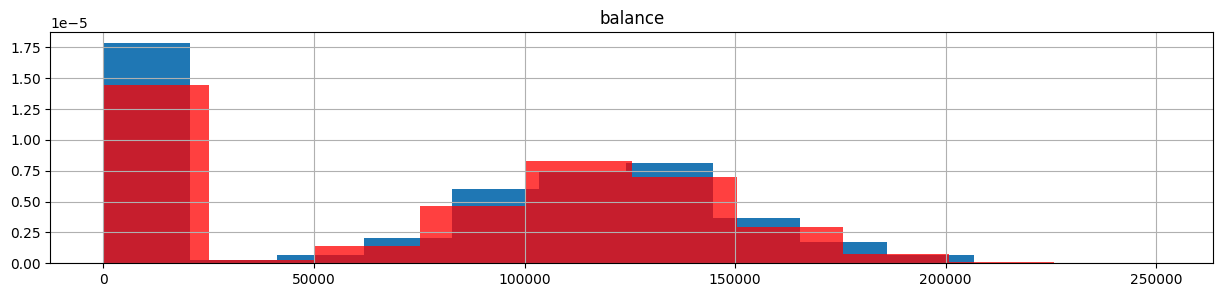

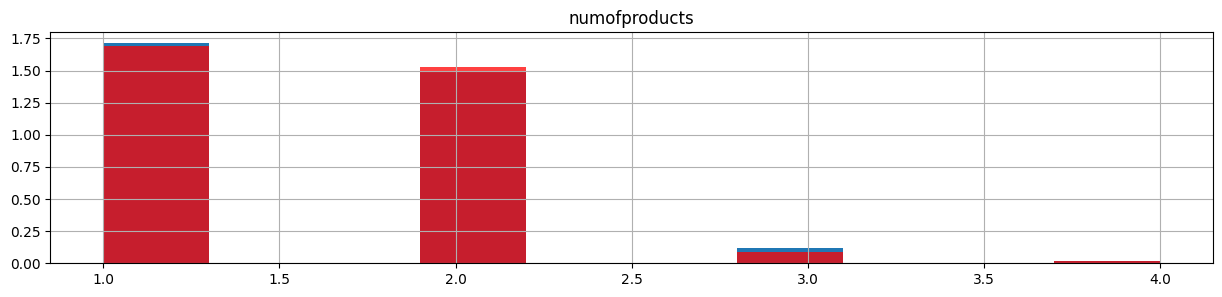

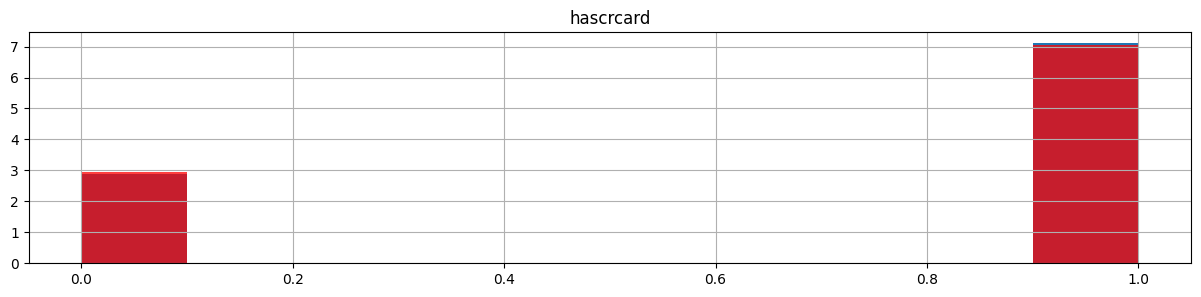

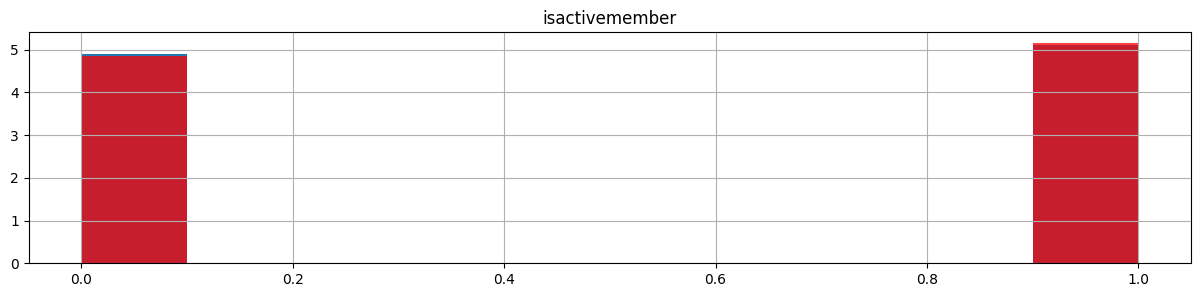

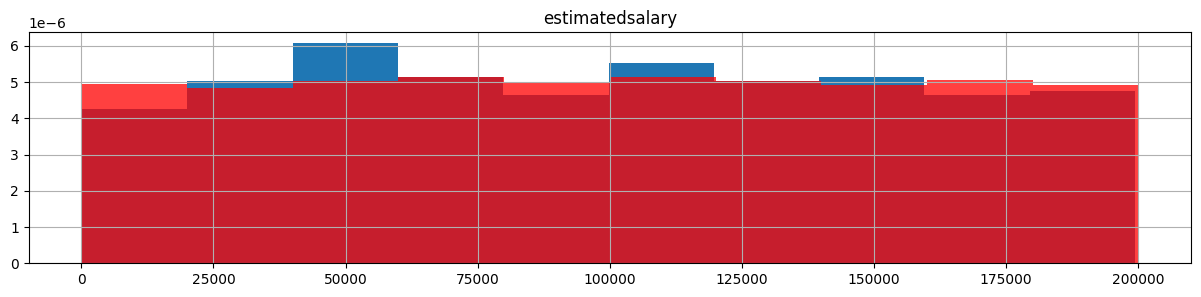

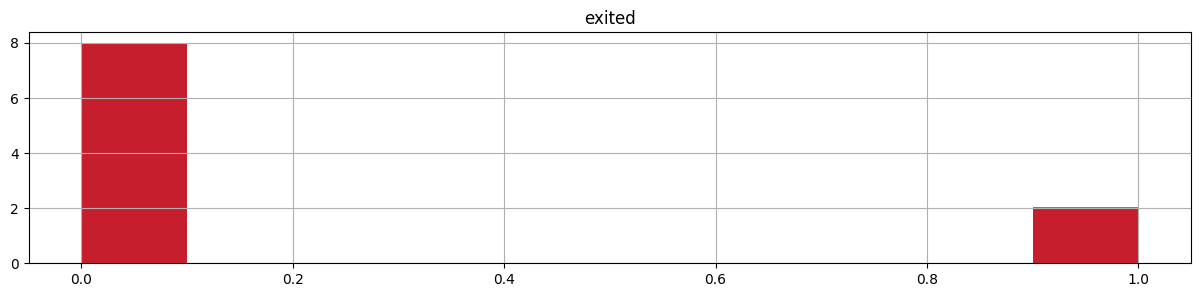

In [9]:
df2=df[df['tenure'].isna()]
for column in df.columns:
    if df[column].dtype != 'object':
        ax=df2.hist(column=column, figsize = (15,3), density=True)
        df.hist(column=column, figsize = (15,3), ax=ax, alpha=0.75, density=True, color = 'r')
        plt.show()

Видно, что распределения близки

Из расчетов ниже видно, что:
- Параметр принимает дискретное значение от 0 до 10, причем нулей почти троекратно меньше, чем других значений
- Пропусков 900. Если все пропуски заполнить 0, это значительно изменит распределение

In [10]:
df.groupby('tenure')['tenure'].count()

tenure
0     382
1     952
2     950
3     928
4     885
5     927
6     881
7     925
8     933
9     882
10    446
Name: tenure, dtype: int64

In [11]:
df['tenure'].isna().sum()

909

- Согласно проведенному анализу оснований для присвоения пропущенным значениям столбца tenure значения 0 или другого отличного от медианы значения нет
- В идеале, для принятия информированного решения необходимо вернуться к инженерам, подготовившим входные данные и уточнить причины отсутствия параметров, а также адекватность низкой частоты величины tenure 0 (действительно ли новые клиенты стали реже появляться в последний год?)
- За неимением такой возможности в данной задаче заменяем пропущенные значения медианным

0


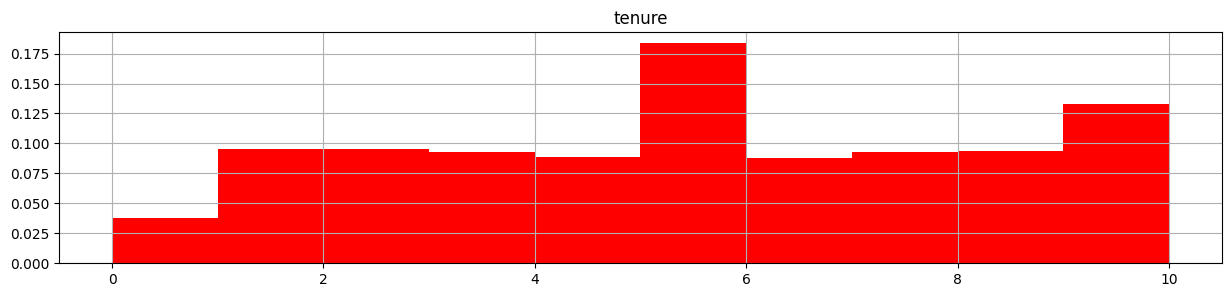

In [12]:
df.loc[df['tenure'].isna(),'tenure']=df['tenure'].median();
print(df['tenure'].isna().sum())
df.hist(column='tenure', figsize = (15,3), density=True, color = 'r');

### Кодировка категорийных признаков и проверка взаимозависимости признаков

- Для оценки взаимозависимости проведем кодировку категорийных признаков, однако, не будем при этом изменять основной dataframe
- Кодировка и нормализация признаков будет сделана после раздления на выборки

Функция для кодировки с использованием OHE. 

Предусмотрена опция делать fit на тренировчном сете, а считать на другом

In [13]:
def one_hot_encode_columns(df_train, df_transform, target_cols, drop_first = True):   
    df_processed = df_transform.copy()
    df_processed.reset_index(inplace=True, drop=True)
    
    for target_col in target_cols:
        try:
            cat_cols_encoded = []

            #имена новых столбцов
            for cat in list(df_processed[target_col].unique()):
                cat_cols_encoded.append('ohe_'+cat)

            oh_encoder = OneHotEncoder(sparse=False)
            oh_encoder.fit(df_train[[target_col]])
            
            #возвращаем трансформированные данные в формате датафрейма
            df_enc = oh_encoder.transform(df_processed[[target_col]])            
            df_enc = pd.DataFrame(df_enc, columns=cat_cols_encoded)

            #убираем первый столбец вручную (избегаем dummy error)
            if drop_first:
                df_enc.drop(columns=df_enc.columns[0], axis=1, inplace=True)

            #объединяем с основыным датафреймом
            df_processed = df_processed.join(df_enc)

            #убираем обработанный столбец
            df_processed.drop(columns=target_col, axis=1, inplace=True)
        except:
            print(f'Ошибка при кодировании столбца {target_col}')
            
    return df_processed

Заодно напишем фунцию кодирования методом Ordinal Encoding

In [14]:
def ordinary_encode_columns(df_train, df_transform, target_cols):   
    df_processed = df_transform.copy()
    df_processed.reset_index(inplace=True, drop=True)
    
    for target_col in target_cols:
        try:
            oe_encoder = OrdinalEncoder()
            oe_encoder.fit(df_train[[target_col]])
            #возвращаем трансформированные данные в формате датафрейма
            df_enc = oe_encoder.transform(df_transform[[target_col]])
            df_enc = pd.DataFrame(df_enc, columns=['oe_'+target_col])
            #объединяем с основыным датафреймом
            df_processed = df_processed.join(df_enc)

            #убираем обработанный столбец
            df_processed.drop(columns=target_col, axis=1, inplace=True)
        except:
            print(f'Ошибка при кодировании столбца {target_col}')
        print(oe_encoder.categories_[0])        
    return df_processed

И (по аналогии) фунцию для трансформации данных

In [15]:
def transform_columns(df_train, df_transform, target_cols, scaler_type = 'StandardScaler'):
    if scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    scaler.fit(df_train[target_cols]) 
    df_transform[target_cols] = scaler.transform(df_transform[target_cols]) 

In [16]:
df_temp = one_hot_encode_columns (df_train=df, df_transform=df, target_cols= ['geography', 'gender'])
df_temp

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,ohe_Spain,ohe_Germany,ohe_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.0,0.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1,0.0,0.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,0.0,0.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0.0,0.0,1.0
9996,516,35,10,57369.61,1,1,1,101699.77,0,0.0,0.0,1.0
9997,709,36,7,0.00,1,0,1,42085.58,1,0.0,0.0,0.0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1.0,0.0,1.0


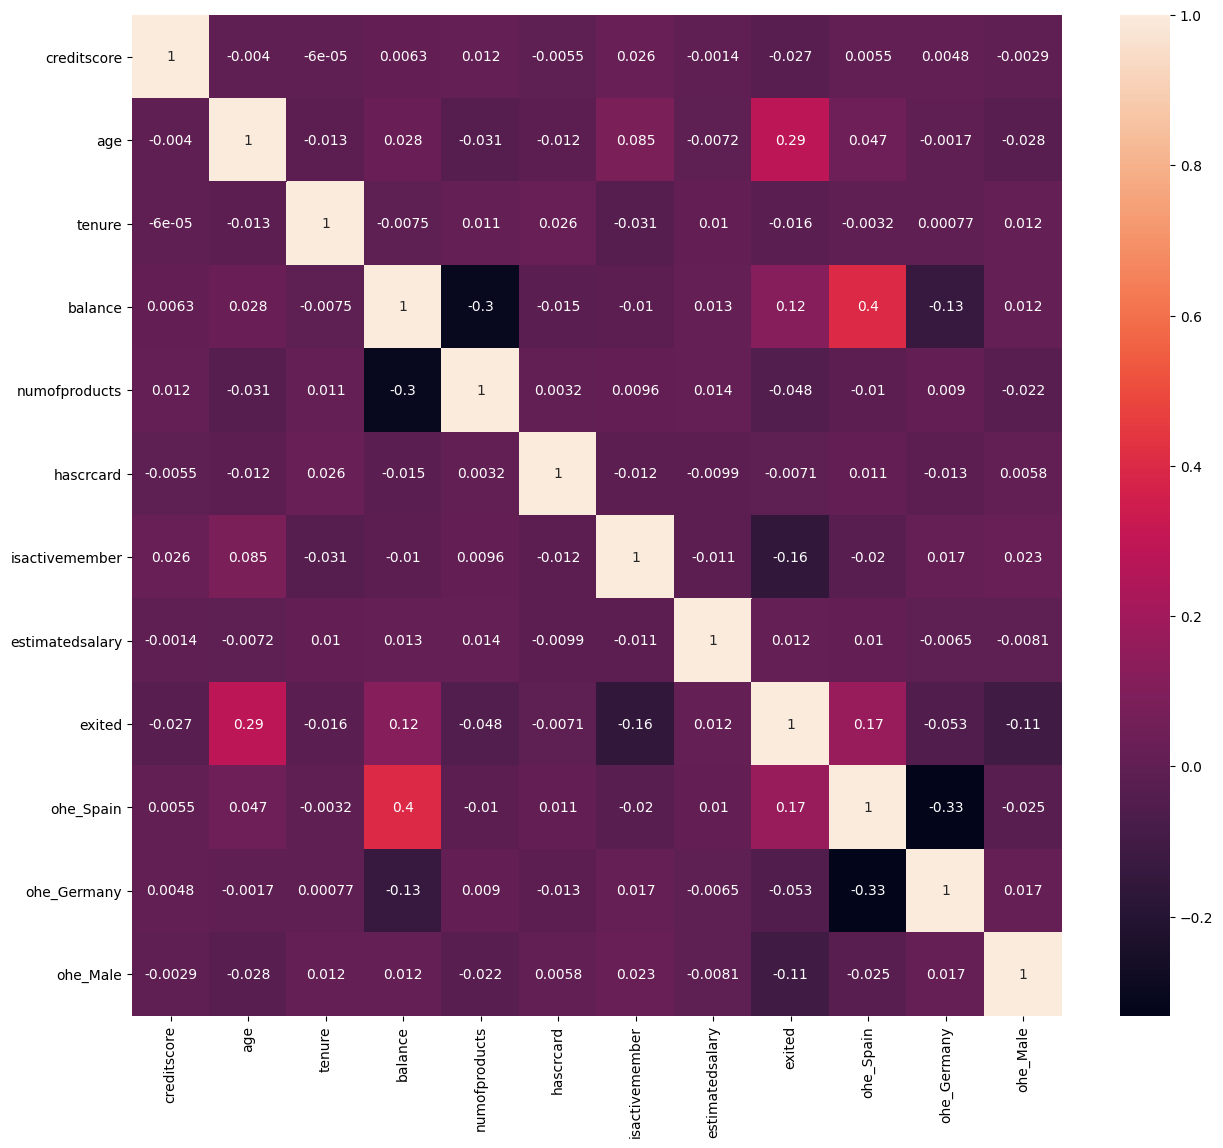

In [17]:
plt.figure(figsize=(15, 13));
sns.heatmap(df_temp.corr(), annot=True);

Не наблюдается высокой (>0.5) степени взаимозависимости между признаками

### Выводы по подготовке данных

- Данные полные за исключением параметра tenure (сколько лет человек является клиентом банка), для которого отсутствуют 10% значений
- Типы данных адекватны, однако столбцу tenure следует присвоить целочисленный тип
- Столбцы, которые не нужны для построения модели, убраны. Имена остальных столбцов приведены к стандартному виду
- Визуализация распределения входные данные подтверждает их адекватность. При этом
    - отмечается дисбаланс классов целевого признака (доля ушедших клиентов - около 20%)
    - распределение параметра tenure исследовано дополнительно
- Согласно проведенному анализу оснований для присвоения пропущенным значениям столбца tenure значения 0 или другого отличного от медианы значения нет. В идеале, для принятия информированного решения необходимо вернуться к инженерам, подготовившим входные данные и уточнить причины отсутствия параметров, а также адекватность низкой частоты величины tenure 0. За неимением такой возможности в данной задаче пропущенные значения заменены медианным
- Категорийные признаки (gender, geography) будут перекодированы в численные на следующем этапе
- Проверка мультиколлениарности не выявила существенно взаимозависимых признаков
- Масштабирование (scaling) будем проводить на тренировочной выборке ниже, проверяя, помогает ли это улучшить качество модели 

## Исследование задачи

### Баланс классов

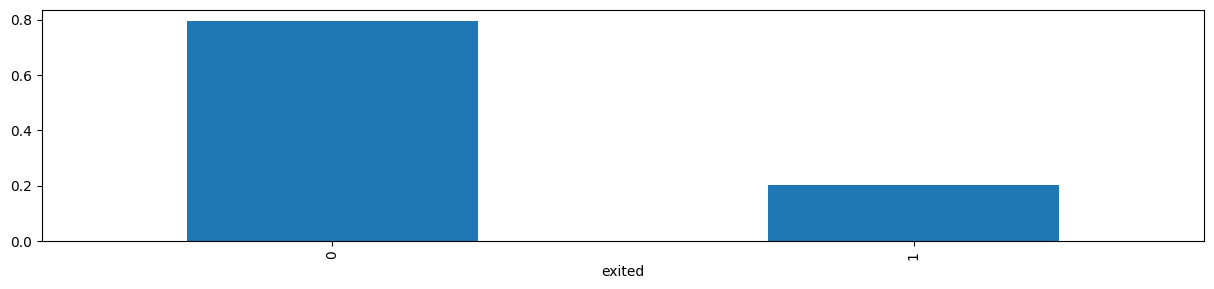

In [18]:
(df.groupby('exited')['exited'].count()/df.shape[0]).plot(kind='bar', figsize = (15,3));

Классы несбалансированы. Положительный класс встречается в 20% объектов

### Оптимизация моделей без учета дисбаланса

#### Подготовка выборок

Готовим выборки train, valid и test

In [19]:
features=df.drop(['exited'], axis=1)
target=df['exited']

features_train, features_test, target_train, target_test = train_test_split (features, target, test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split (features_train, target_train, test_size=0.25, random_state=12345)

#### Создание класса для оптимизации моделей 

Создаем класс для работы с моделями: 
- выбор типа модели и гиперпараметров
- оптимизация с использованием gridsearchcv
- расчет метрик классификации

In [20]:
class ml_model:
     
    #инициализируем класс, задавая тип модели, диапазон параметров модели (для оптимизации) и входные данные (features, targets)
    def __init__(self, model, params, 
                 features_train, target_train, features_valid, target_valid,
                 random_state=12345):
        self.model = model  
        self.params = params  
        self.features_train = features_train
        self.target_train = target_train
        self.features_valid = features_valid
        self.target_valid = target_valid        
        self.random_state = random_state
        
        #Аттрибуты для прогнозных результатов для валидационной и тестовой выборки
        self.probabilities_valid = None
        self.predictions_valid = None
        
        #Аттрибут для хранения оптимизированной модели 
        self.optimized_model = None

        #Оптимизируем гиперпараметры в рамках заданой сетки во время инициализации объекта
        self.create_optimized_model()
                   
    #функция для оптимизации модели методом GridSearchCV
    def create_optimized_model(self):
        #максимизируем метрику f1
        clf = GridSearchCV(self.model,
                           param_grid = self.params,
                           scoring='f1',
                           cv=None) #default 5 fold
        
        #итерируем на тренировочном датасете
        clf.fit(self.features_train, self.target_train)
        
        #выводим результаты                
        print("Tuned Hyperparameters :", clf.best_params_)
        print("f1_score на тестовой выборке:",clf.best_score_)
        
        #сохраняем модель и обучаем на тренировочном сете
        self.optimized_model = clf.best_estimator_
        self.optimized_model.fit(self.features_train, self.target_train)
        
        #с использованием оптимизированной модели делаем прогноз признаков и вероятности признаков на валидационной выборке 
        self.probabilities_valid = self.optimized_model.predict_proba(self.features_valid)
        self.predictions_valid = self.optimized_model.predict(self.features_valid)
                              
    #функция для расчета f1_score
    def f1_score (self):
        print(f' f1_score на валидационной выборке: {f1_score(self.target_valid, self.predictions_valid)} ')
                      
    #функция для построения pr-curve и вывода сопутствующих метрик
    def pr_curve (self):
        precision, recall, thresholds = precision_recall_curve(self.target_valid, self.probabilities_valid[:, 1])
        plt.figure(figsize=(15, 6))
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('P-R Curve')
        plt.show()
        print(f'Recall score: {recall_score(self.target_valid, self.predictions_valid)}')
        print(f'Precision score: {precision_score(self.target_valid, self.predictions_valid)}')
        print(f'f1 score: {f1_score(self.target_valid, self.predictions_valid)}')            
            
    #функция для построения roc-curve и вывода сопутствующих метрик
    def roc_curve (self):
        fpr, tpr, thresholds = roc_curve(self.target_valid, self.probabilities_valid[:, 1])
        plt.figure(figsize=(15, 6))
        plt.step(fpr, tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])            
        plt.title('ROC Curve')
        plt.show()
        print(f'AUC/ROC: {roc_auc_score(self.target_valid, self.predictions_valid)}')                      

#### Логистическая регрессия

Для логистической регрессии кодируем категориальные признаки через OHE:
- Для этого используем ранее созданную функцию one_hot_encode_columns
- Тренируем кодировщик на train, применяем преобразование ко всем выборкам

In [21]:
features_train_lr = one_hot_encode_columns (df_train=features_train, df_transform=features_train, target_cols= ['geography', 'gender'])
features_valid_lr = one_hot_encode_columns (df_train=features_train, df_transform=features_valid, target_cols= ['geography', 'gender'])
features_test_lr = one_hot_encode_columns (df_train=features_train, df_transform=features_test, target_cols= ['geography', 'gender'])

Нормализуем данные

In [22]:
transform_columns(features_train, features_train_lr, ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary'], 'StandardScaler')
transform_columns(features_train, features_valid_lr, ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary'], 'StandardScaler')
transform_columns(features_train, features_test_lr, ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary'], 'StandardScaler')

In [23]:
features_train_lr

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,ohe_Germany,ohe_Spain,ohe_Male
0,-0.134048,-0.078068,-0.369113,0.076163,0.816929,0,1,0.331571,0.0,0.0,0.0
1,-1.010798,0.494555,-0.007415,0.136391,-0.896909,1,1,-0.727858,0.0,0.0,1.0
2,0.639554,1.353490,-1.454209,0.358435,-0.896909,1,1,-0.477006,1.0,0.0,1.0
3,-0.990168,2.116987,-1.092511,0.651725,-0.896909,1,1,-0.100232,0.0,0.0,0.0
4,0.567351,0.685430,0.715982,0.813110,0.816929,1,1,0.801922,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5995,-0.618839,-0.268942,1.801078,0.744283,-0.896909,0,1,0.803658,1.0,0.0,1.0
5996,1.743227,-1.032439,1.077681,-1.232442,-0.896909,1,1,-1.098797,0.0,0.0,0.0
5997,0.567351,-0.650691,1.439380,-1.232442,0.816929,0,0,-1.202257,0.0,0.0,1.0
5998,-0.412545,0.494555,-1.092511,0.615524,-0.896909,1,1,-0.038931,1.0,0.0,1.0


Задаем модель как класс

In [24]:
lr = ml_model (model = LogisticRegression(),
               params = {
                   'penalty' : ['none', 'l1','l2', 'elasticnet'],
                   'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'C': [0.01, 0.1, 1, 10, 100]
               },
               features_train = features_train_lr,
               target_train = target_train,
               features_valid = features_valid_lr,
               target_valid = target_valid
              )

Tuned Hyperparameters : {'C': 0.01, 'penalty': 'none', 'solver': 'newton-cg'}
f1_score на тестовой выборке: 0.32452210332349307


In [25]:
lr.f1_score()

 f1_score на валидационной выборке: 0.30451127819548873 


Для несбалансированной метрики используем P-R Curve, ROC curve будем использовать после балансировки

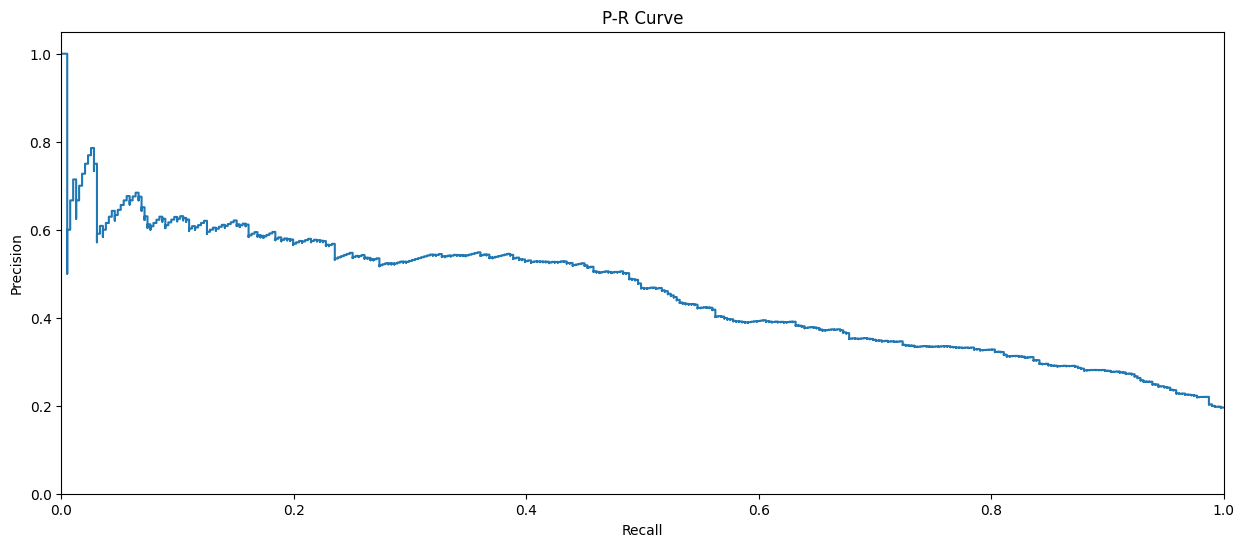

Recall score: 0.2071611253196931
Precision score: 0.574468085106383
f1 score: 0.30451127819548873


In [26]:
lr.pr_curve()

Для полноты картины строим и ROC-кривую

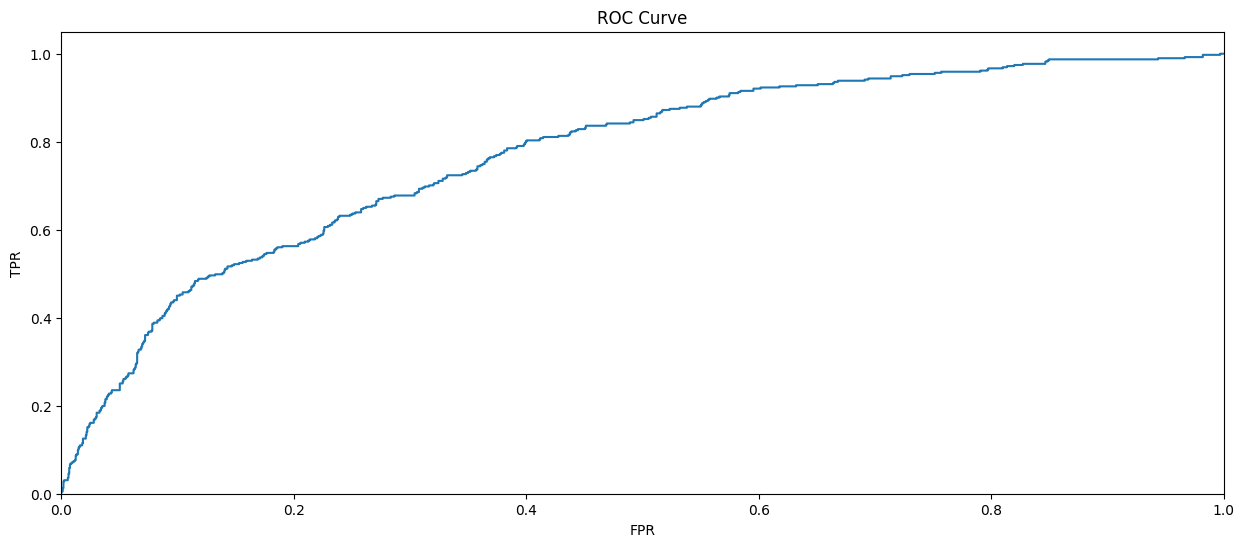

AUC/ROC: 0.5849354414665587


In [27]:
lr.roc_curve()

Качество модели на основе логистической модели после оптимизации гиперпараметров недостаточно

#### Случайный лес

Для данной модели кодируем признаки через OE

In [28]:
features_train_rf = ordinary_encode_columns(df_train=features_train, df_transform=features_train, target_cols= ['geography', 'gender'])
features_valid_rf = ordinary_encode_columns (df_train=features_train, df_transform=features_valid, target_cols= ['geography', 'gender'])
features_test_rf = ordinary_encode_columns (df_train=features_train, df_transform=features_test, target_cols= ['geography', 'gender'])

['France' 'Germany' 'Spain']
['Female' 'Male']
['France' 'Germany' 'Spain']
['Female' 'Male']
['France' 'Germany' 'Spain']
['Female' 'Male']


Нормализуем данные

In [29]:
transform_columns(features_train, features_train_rf, ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary'], 'StandardScaler')
transform_columns(features_train, features_valid_rf, ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary'], 'StandardScaler')
transform_columns(features_train, features_test_rf, ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary'], 'StandardScaler')

In [30]:
features_train_rf

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,oe_geography,oe_gender
0,-0.134048,-0.078068,-0.369113,0.076163,0.816929,0,1,0.331571,0.0,0.0
1,-1.010798,0.494555,-0.007415,0.136391,-0.896909,1,1,-0.727858,0.0,1.0
2,0.639554,1.353490,-1.454209,0.358435,-0.896909,1,1,-0.477006,1.0,1.0
3,-0.990168,2.116987,-1.092511,0.651725,-0.896909,1,1,-0.100232,0.0,0.0
4,0.567351,0.685430,0.715982,0.813110,0.816929,1,1,0.801922,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
5995,-0.618839,-0.268942,1.801078,0.744283,-0.896909,0,1,0.803658,1.0,1.0
5996,1.743227,-1.032439,1.077681,-1.232442,-0.896909,1,1,-1.098797,0.0,0.0
5997,0.567351,-0.650691,1.439380,-1.232442,0.816929,0,0,-1.202257,0.0,1.0
5998,-0.412545,0.494555,-1.092511,0.615524,-0.896909,1,1,-0.038931,1.0,1.0


Инициализируем модель как класс

In [31]:
rf = ml_model (model = RandomForestClassifier(),
               params = {
                   'n_estimators': np.arange(20,100,20), #[10, 30, 3],
                   'max_features': ['log2'], #['auto', 'sqrt', 'log2'],
                   'max_depth' : np.arange(10,15,1), #np.arange(5,20,2),
                   'criterion' : ['gini'] #['gini', 'entropy']
               },
               features_train = features_train_rf,
               target_train = target_train,
               features_valid = features_valid_rf,
               target_valid = target_valid
              )

Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'n_estimators': 60}
f1_score на тестовой выборке: 0.5811248976334056


In [32]:
rf.f1_score()

 f1_score на валидационной выборке: 0.5335515548281506 


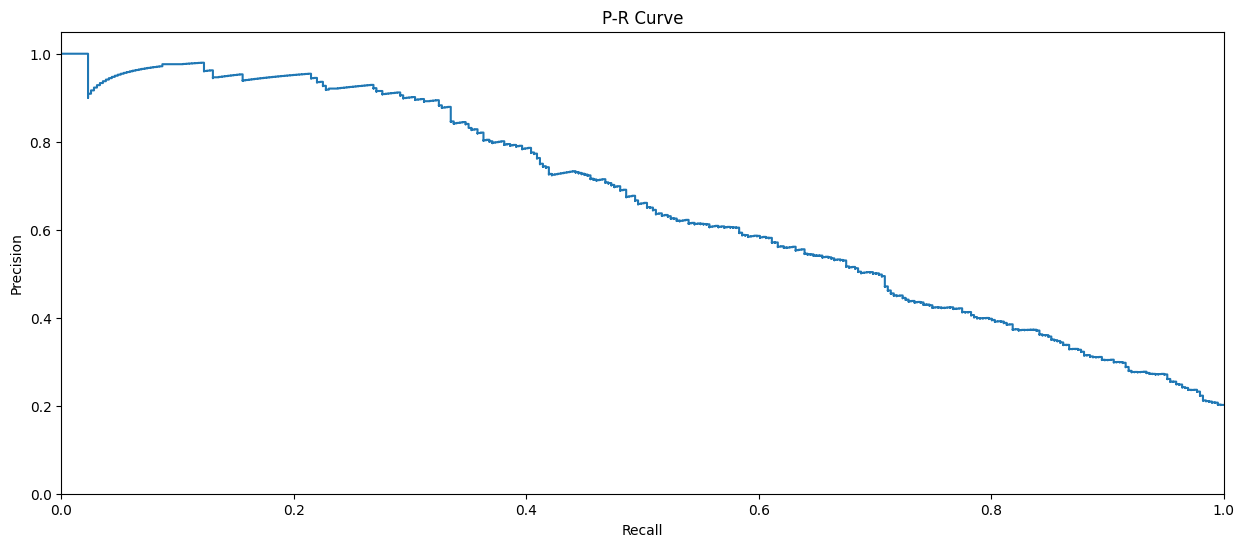

Recall score: 0.41687979539641945
Precision score: 0.740909090909091
f1 score: 0.5335515548281506


In [33]:
rf.pr_curve()

Для полноты картины строим и ROC-кривую

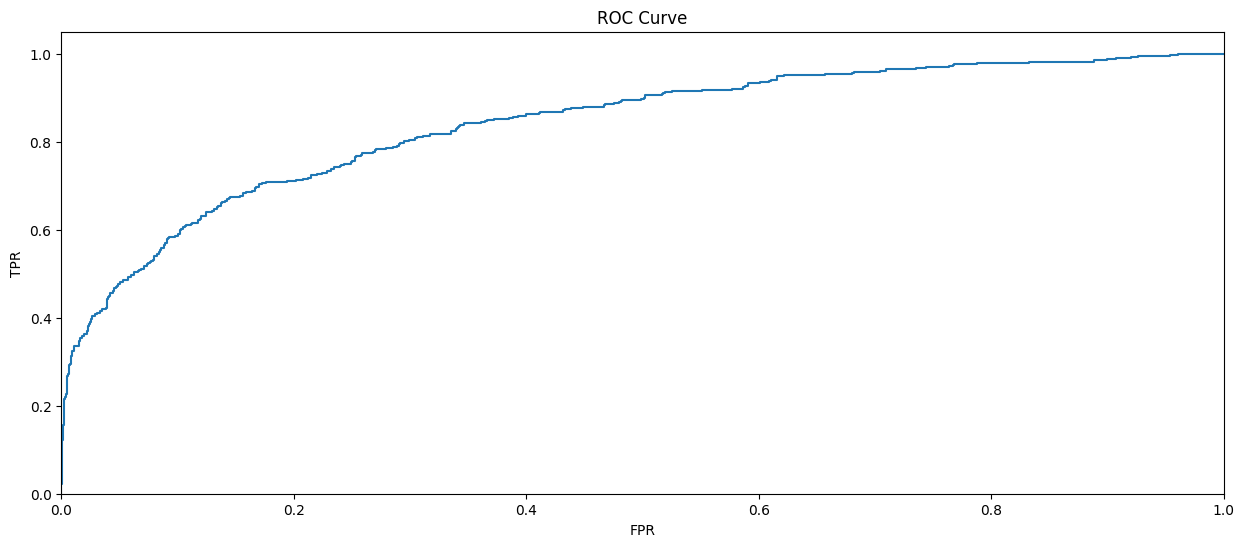

AUC/ROC: 0.6907270325645863


In [34]:
rf.roc_curve()

- Результаты по модели случайного леса значительно лучше и приближаются к требуемому значению метрики f1
- Ниже проверим улучшится ли качество мадели после балансировки классов

### Выводы по исследованию задачи до учета дисбаланса

- Данные были стандратно разбиты на 3 выборки
- Дополнительно к шагам по обрабоке данных до разбиения, после него на основе тренировочной выборки:
    1. были обработаны категорийные признаки (выбор между OHE и OE зависит от типа модели)
    2. были нормализованы численные данные
- Для оптимизации гиперпараметров применено gridsearchcv, для тестирования на валидационной выборки взяты наилучшее модели
- Результаты по модели RandomForest значительно лучше, чем по логистической регрессии, по всем метрикам, включая f1 и AUC_ROC - именно данная модель будет принята для дальнейшей оптимизации с учетом дисбаланса

## Борьба с дисбалансом

### Функции для downsapling и upsampling

Задаем функции downsapling и upsampling

In [35]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1] 
    
    #upsample the minority class
    features_upsampled = features_zeros.append(resample(features_ones,random_state=12345,n_samples=features_zeros.shape[0],replace=True))
    target_upsampled = target_zeros.append(resample(target_ones,random_state=12345,n_samples=target_zeros.shape[0],replace=True))

    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345)
    
    features_upsampled.reset_index(inplace=True, drop=True)
    target_upsampled.reset_index(inplace=True, drop=True)
    
    return features_upsampled, target_upsampled

In [36]:
def downsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1] 
    
    #upsample the minority class
    features_upsampled = features_ones.append(resample(features_zeros,random_state=12345,n_samples=features_ones.shape[0],replace=True))
    target_upsampled = target_ones.append(resample(target_zeros,random_state=12345,n_samples=target_ones.shape[0],replace=True))

    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345)
    
    features_upsampled.reset_index(inplace=True, drop=True)
    target_upsampled.reset_index(inplace=True, drop=True)
    
    return features_upsampled, target_upsampled

### Upsampling

Сбрасываем индексы таргетов

In [37]:
target_train.reset_index(inplace=True, drop=True)

Количество повторов в upsample для уравнивания классов:

In [38]:
df.groupby('exited')['exited'].count()

exited
0    7963
1    2037
Name: exited, dtype: int64

In [39]:
features_train_rf_ups, target_train_ups = upsample(features_train_rf, target_train, 7963)

In [40]:
print(f'{target_train_ups.sum()} of {target_train_ups.shape[0]}')

4781 of 9562


Инициализируем модель как класс, но с уже со сбалансированной тренировочной выборкой

In [41]:
rf_ups = ml_model (model = RandomForestClassifier(),
               params = {
                   'n_estimators': np.arange(20,100,20), #[10, 30, 3],
                   'max_features': ['log2'], #['auto', 'sqrt', 'log2'],
                   'max_depth' : np.arange(10,15,1), #np.arange(5,20,2),
                   'criterion' : ['gini'] #['gini', 'entropy']
               },
               features_train = features_train_rf_ups,
               target_train = target_train_ups,
               features_valid = features_valid_rf,
               target_valid = target_valid
              )

Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 14, 'max_features': 'log2', 'n_estimators': 80}
f1_score на тестовой выборке: 0.9465931144138221


In [42]:
rf_ups.f1_score()

 f1_score на валидационной выборке: 0.5904761904761905 


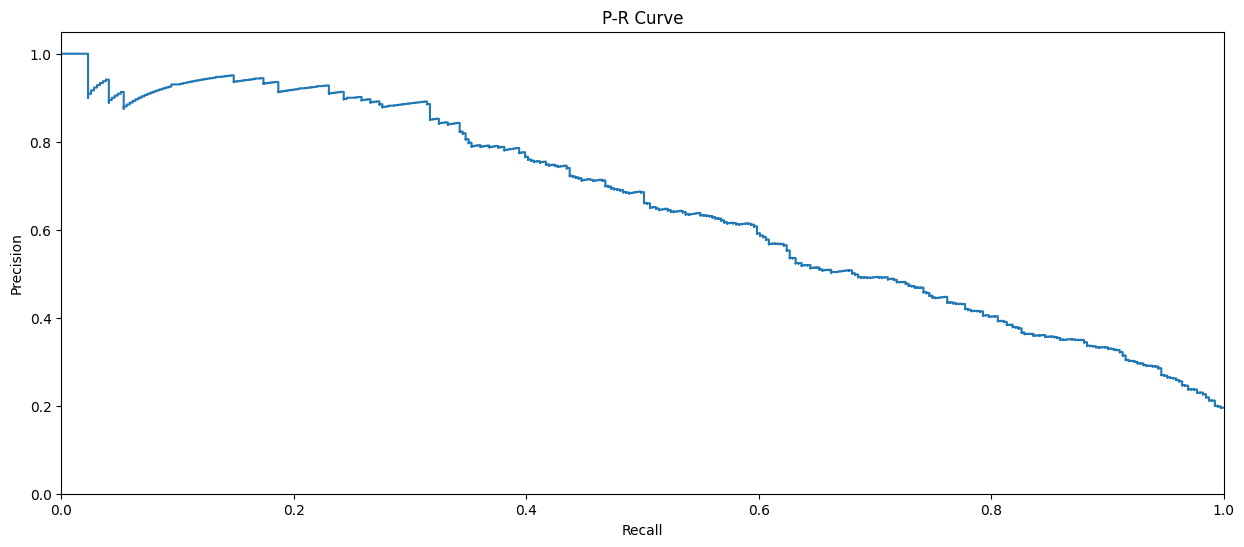

Recall score: 0.5549872122762148
Precision score: 0.6308139534883721
f1 score: 0.5904761904761905


In [43]:
rf_ups.pr_curve()

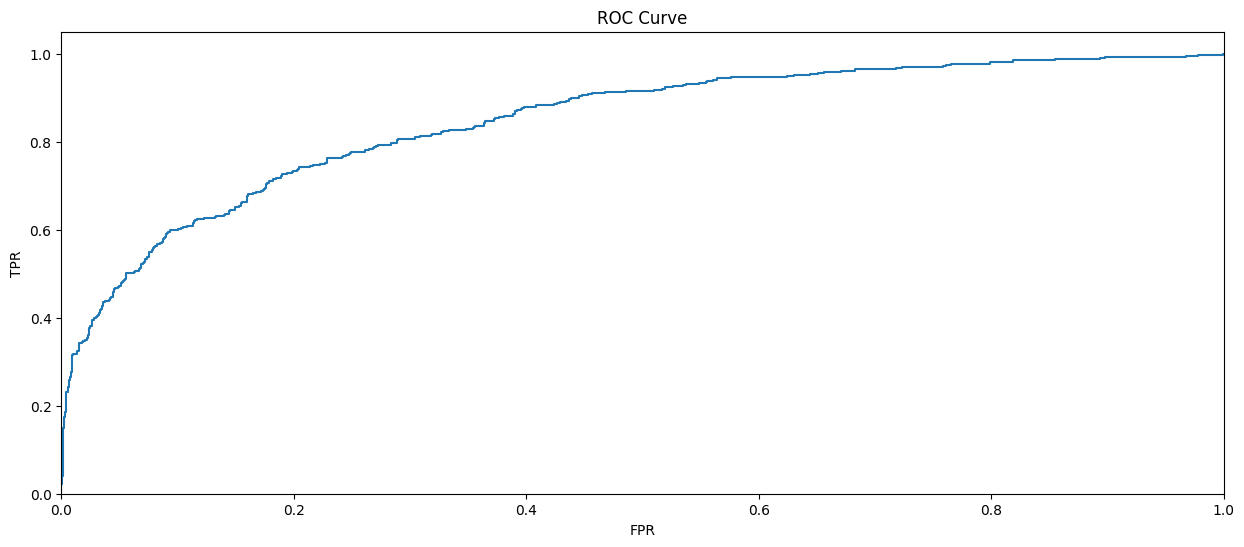

AUC/ROC: 0.7380280996123151


In [44]:
rf_ups.roc_curve()

- Отмечаем повышение качества модели после апсемплинга: f1_score вырос с 0.54 ло 0.58, auc_roc_score вырос до 0.73
- f1_score вырос за счет повышения recall, что, вероятно, связано с большим кол-вом объектов с целевым признаком 1
- f1 score на валидационной выборке близка к целевой 0.58
- **Я не совсем понимаю причину такого высокого (>.9) f1 на тренировочной выборке. Может ли это быть по причине того дупликации объектов? Или у меня где-то техническая ошибка? Сомневаюсь, что модель может быть настолько переобучена**

### Downsampling

Сбрасываем индексы таргетов

In [45]:
target_train.reset_index(inplace=True, drop=True)

Количество повторов в upsample для уравнивания классов:

In [46]:
df.groupby('exited')['exited'].count()

exited
0    7963
1    2037
Name: exited, dtype: int64

In [47]:
features_train_rf_down, target_train_down = downsample(features_train_rf, target_train, 2037)

In [48]:
print(f'{target_train_down.sum()} of {target_train_down.shape[0]}')

1219 of 2438


Инициализируем модель как класс, но с уже со сбалансированной тренировочной выборкой

In [49]:
rf_down = ml_model (model = RandomForestClassifier(),
               params = {
                   'n_estimators': np.arange(50,100,20),
                   'max_features': ['auto', 'sqrt', 'log2'],
                   'max_depth' : np.arange(7,15,2), #np.arange(5,20,2),
                   'criterion' : ['gini'] #['gini', 'entropy']
               },
               features_train = features_train_rf_down,
               target_train = target_train_down,
               features_valid = features_valid_rf,
               target_valid = target_valid
              )

Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 90}
f1_score на тестовой выборке: 0.7893424619725373


In [50]:
rf_down.f1_score()

 f1_score на валидационной выборке: 0.5270758122743683 


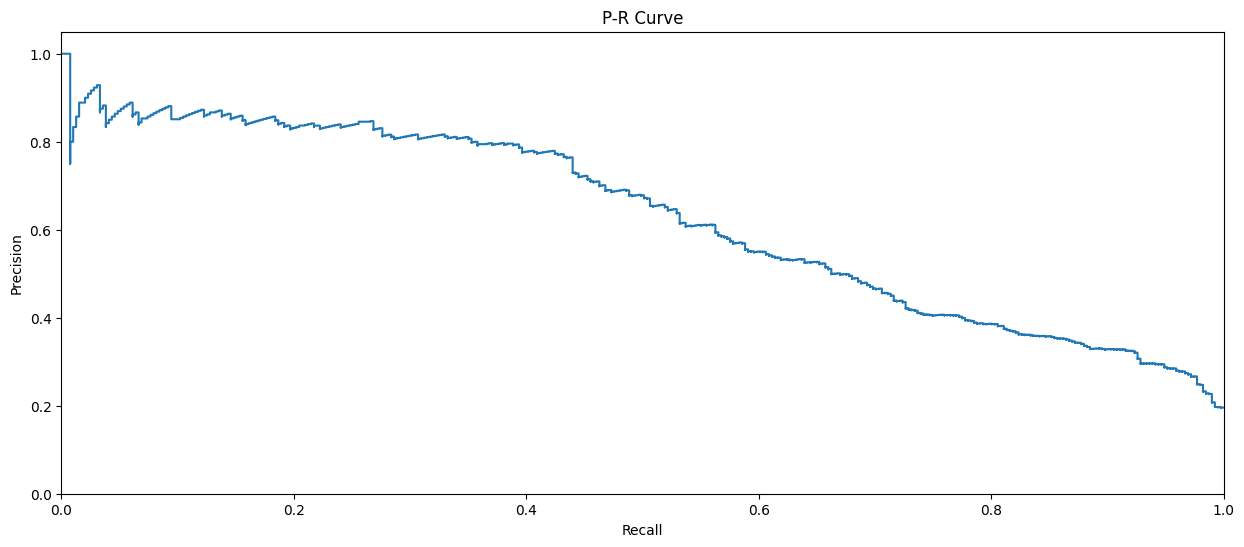

Recall score: 0.7468030690537084
Precision score: 0.4072524407252441
f1 score: 0.5270758122743683


In [51]:
rf_down.pr_curve()

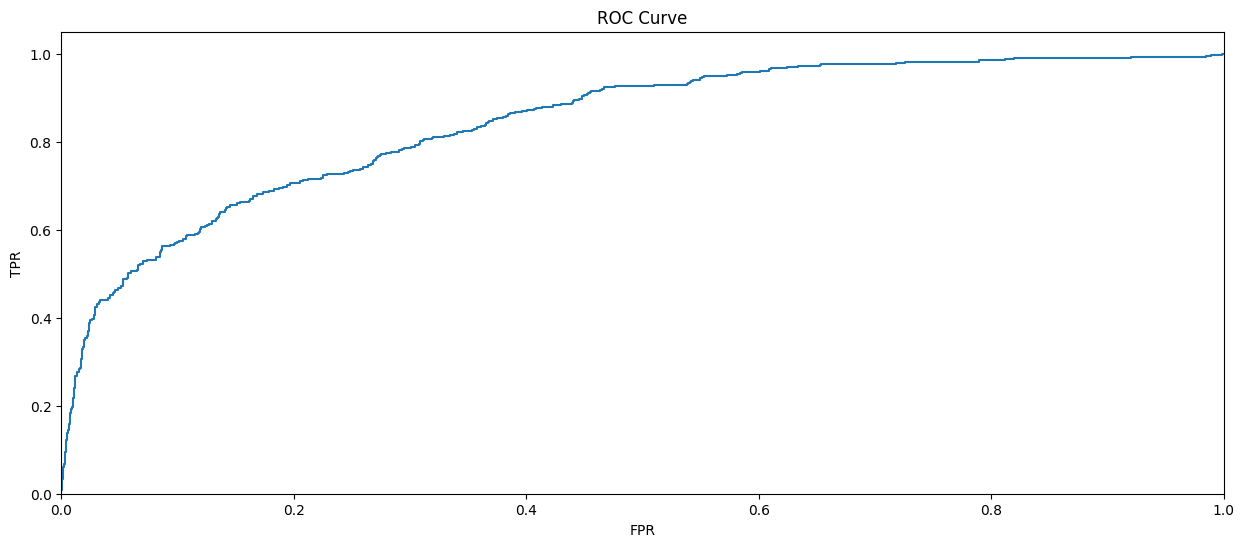

AUC/ROC: 0.7413319260743992


In [52]:
rf_down.roc_curve()

- После даунсемплинга метрика f1 практически не улучшилась по сравнению с обучением на оригинальной выборке, метрика AUC_ROC выросла

### Использование параметра class_weight

Сбрасываем индексы таргетов

In [53]:
target_train.reset_index(inplace=True, drop=True)

Количество повторов в upsample для уравнивания классов:

In [54]:
df.groupby('exited')['exited'].count()

exited
0    7963
1    2037
Name: exited, dtype: int64

Включаем параметры, отвечающие за вес классов в оптимизатор гиперпараметров

In [55]:
rf_weight = ml_model (model = RandomForestClassifier(),
               params = {
                   'class_weight': ['balanced', 'balanced_subsample'],
                   'n_estimators': np.arange(30,80,20),
                   'max_features': ['auto', 'sqrt', 'log2'],
                   'max_depth' : np.arange(8,16,2), #np.arange(5,20,2),
                   'criterion' : ['gini'] #['gini', 'entropy']
               },
               features_train = features_train_rf,
               target_train = target_train,
               features_valid = features_valid_rf,
               target_valid = target_valid
              )

Tuned Hyperparameters : {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
f1_score на тестовой выборке: 0.612586586530337


In [56]:
rf_weight.f1_score()

 f1_score на валидационной выборке: 0.5804816223067174 


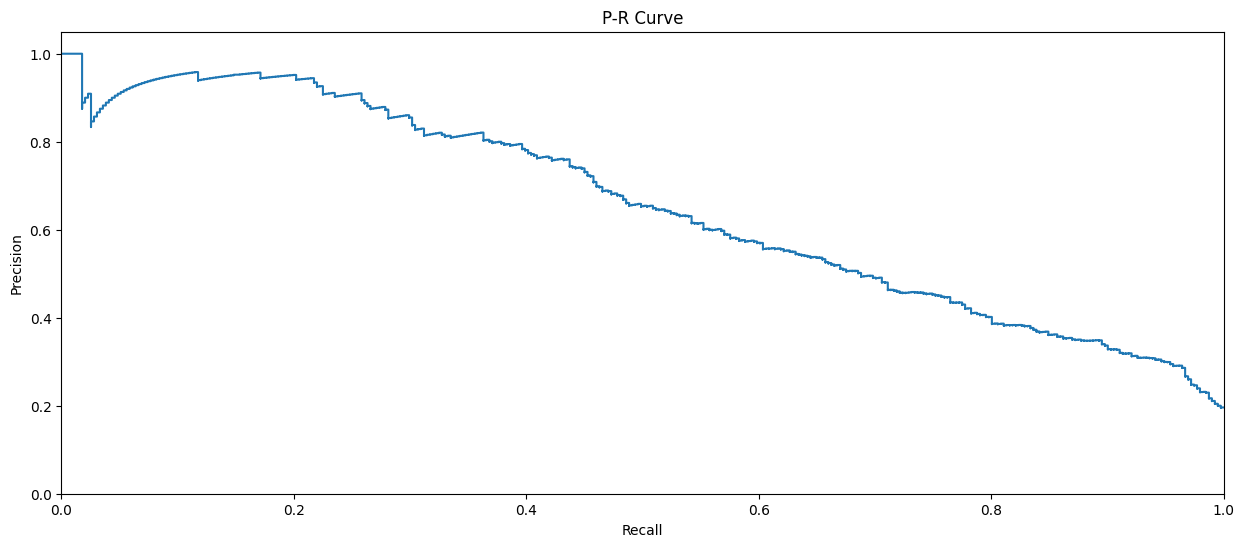

Recall score: 0.5856777493606138
Precision score: 0.5753768844221105
f1 score: 0.5804816223067174


In [57]:
rf_weight.pr_curve()

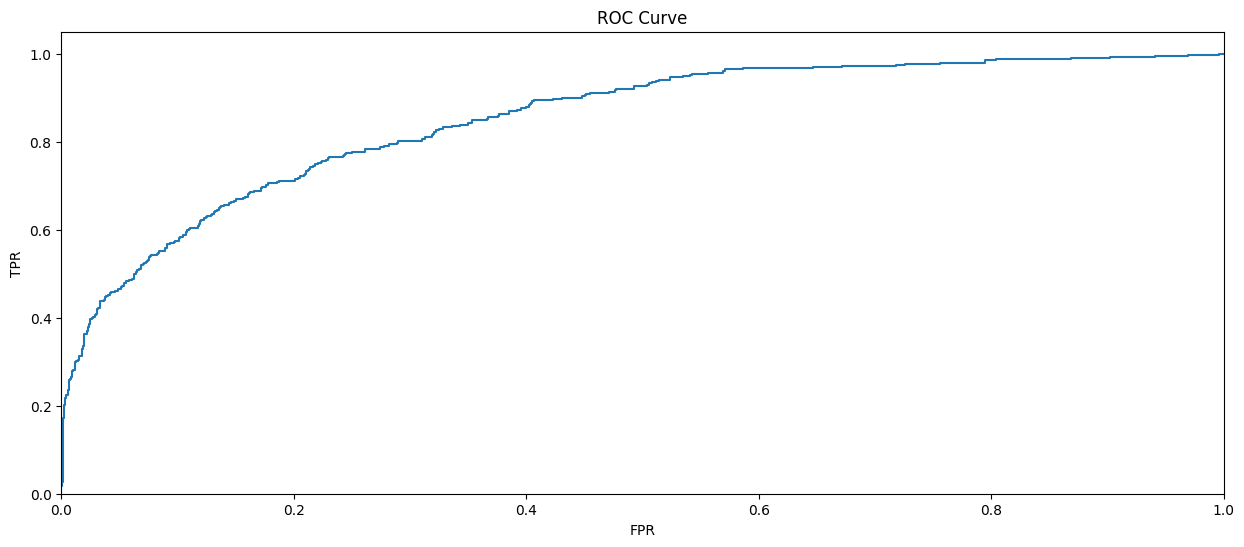

AUC/ROC: 0.7403217833192131


In [58]:
rf_weight.roc_curve()

- Балансировка с использованием параметра class_weight дает результат по метрике f1 аналогичный тому, который получался при "ручном" апсемплинге и характеризуется близкими величинами Recall и Precision.
- Величина AUC/ROC чуть выше, чем при "ручном" upsamplingе

###  Выводы по борьбе с дисбалансом

- Балансировка тренировочной выборки с использованием upsampling дала лучшие результаты, чем использование оригинальной выборки
- Downsampling не улучшил качествно модели
- Взвешивание классов (class_weightning) привело к незначительно лучшим результатам на валидационной выборке, чем "ручной" upsampling
- Для тестирования принимается модель RandomForest с параметром 'class_weight' = 'balanced' и подобранным через gridsearchcv набором других гиперпараметров

## Тестирование модели

In [59]:
best_model = rf_weight

Тестируем лучшую на валидационных выборках модель на тестовом датасете

In [60]:
best_model.optimized_model

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='sqrt', n_estimators=50)

Метрика f1_score на тестовой выборке:

In [61]:
f1_score(best_model.optimized_model.predict(features_test_rf), target_test)

0.6238095238095238

- Метрика f1 на тестовой выборке существенно выше порогового значения 0.58. Это победа?

Добавляем sanity check

In [62]:
dummy_model = DummyClassifier(strategy='uniform', random_state=12345)
dummy_model.fit(features_test_rf, target_test)
dummy_model_prediction=dummy_model.predict(features_test_rf)
print(f'Точность dummy модели: {accuracy_score(dummy_model_prediction,target_test)}')

Точность dummy модели: 0.511


Модель прошла Sanity check

# Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*